## Bayesian optimization to infer Fractional KelvinVoigt model fitting parameters for the oscillation data of chia

First, we are importing a variety of essential libraries that will help us with numerical computations, data manipulation, plotting, machine learning, Bayesian optimization, and other specialized tasks.

### Libraries:
- **NumPy (`numpy`)**: A fundamental package for numerical operations in Python.
- **Pandas (`pandas`)**: A powerful data manipulation and analysis library.
- **Matplotlib (`matplotlib.pyplot`)**: A plotting library used for creating static, animated, and interactive visualizations.
- **SciPy Special Functions (`scipy.special`)**: Specifically importing the gamma function for mathematical computations.
- **PyTorch (`torch`)**: A deep learning library for tensor computations and building neural networks.
- **BoTorch and GPyTorch**: Libraries for Gaussian Process Regression:
  - `SingleTaskGP`: For constructing Gaussian Process models.
  - `Standardize`: For standardizing outcomes.
  - `ExactMarginalLogLikelihood`: For exact marginal log likelihood calculation.
  - `fit_gpytorch_mll`: For fitting GP models.
- **Sobol Sequence (`sobol_seq`)**: For generating Sobol sequences for quasi-random sampling.
- **BoTorch Acquisition and Optimization**:
  - `qExpectedImprovement`: For Monte Carlo-based expected improvement.
  - `optimize_acqf`: For optimizing the acquisition function.
- **Scikit-Learn Preprocessing (`sklearn.preprocessing`)**: A collection of scalers for feature scaling, including:
  - `MinMaxScaler`
  - `RobustScaler`
  - `StandardScaler`
  - `MaxAbsScaler`
- **pyRheo (`pyRheo.oscillation_evaluator`)**: A custom library for evaluating properties in oscillation.
- **SciencePlots (`scienceplots`)**: A library to enhance Matplotlib plots with scientific visual styles.

These imports will provide all the necessary tools for the subsequent analysis and model building steps in this notebook.


In [19]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import minimize
import torch
import time as timer
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
import sobol_seq
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.logei import qLogExpectedImprovement, qLogNoisyExpectedImprovement
from botorch.acquisition.analytic import LogExpectedImprovement, LogProbabilityOfImprovement
from botorch.optim.optimize import optimize_acqf
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, MaxAbsScaler
from gpytorch.kernels import RBFKernel, MaternKernel, ScaleKernel, LinearKernel, RQKernel
from gpytorch.constraints import Interval
from pyRheo.oscillation_evaluator import SAOSEvaluator
import scienceplots
plt.style.use(['science', 'nature', 'retro'])

## Random Error Generation, Objective Function, Sobol Sampling and Model Initialization

In this section, we define various key functions and setup procedures required for our model analysis and optimization:



In [20]:
##### Error function (optional noise injection, default off)
def createRandomError(n, std):
    return np.random.normal(loc=1, scale=std, size=n)

# Objective function to minimize (RRS weighted by true values)
def objective(params):
    logG, logV, alpha, beta = params
    G = 10 ** logG
    V = 10 ** logV
    params_no_scale = G, V, alpha, beta
    model = "FractionalKelvinVoigt"
    evaluator = SAOSEvaluator(model=model)
    # Compute oscillation data
    model_values = evaluator.compute_model(params_no_scale, omega) 
    # Add noise
    error = createRandomError(omega.shape[0], 0.00)
    model_values_noisy = np.multiply(model_values, error)
    # Define objective functions
    obj_gp = np.sum(((G_prime - model_values_noisy[0]) / G_prime) ** 2) 
    obj_gpp = np.sum(((G_double_prime - model_values_noisy[1]) / G_double_prime) ** 2) 
    obj1 = obj_gp + obj_gpp
    return -np.log10(obj1) # we take the negative because the EI by default maximizes and we are looking to minimize


# Function to create Sobol samples
def sobol_sample(space, n_samples):
    sobol_samples = sobol_seq.i4_sobol_generate(len(space), n_samples)
    sobol_scaled = sobol_samples * (space[:, 1] - space[:, 0]) + space[:, 0]
    return np.array(sobol_scaled)


# Initialize model function for single-objective problem
def initialize_model(train_x, train_obj):
    train_obj = train_obj.unsqueeze(-1)  # Add dimension for single task GP
    model = SingleTaskGP(
        train_x, train_obj,
        covar_module= ScaleKernel(
            MaternKernel(
                nu=1.5,
                #ard_num_dims=10,
                has_lengthscale=True,
                #lengthscale_constraint=Interval(0.001, 10),
                outcome_transform=None,
                train_Yvar=None
            )
        )
    )
    
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model


# Compute the qEI acquisition function to find new candidate points that maximize the objective
def compute_qei_acquisition_function(model, train_y, bounds, q_batch_size):
    acq_func = qLogExpectedImprovement(
        model=model,
        best_f=train_y.max(),  # since we're maximizing the negative of the objective error
        #maximize=True
    )
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=q_batch_size,
        num_restarts=1,
        raw_samples=200,
        options={"batch_limit": 5},
        sequential=True # Recommend to use True when the batch is higher than 5.
    )
    return candidates


## Loading Rheological Data and Defining Search Space

In this section, we load the rheological data from a CSV file and define the search space bounds for our parameter optimization.

In [21]:
# Load rheological data
data = pd.read_csv('./data/chia_pudding/oscillation_chia_data.csv', delimiter=',', decimal=".")
omega = data['Angular Frequency'].values
G_prime = data['Storage Modulus'].values
G_double_prime = data['Loss Modulus'].values
y_true = np.concatenate([G_prime, G_double_prime])

# Define search space bounds
param_space = np.array([
    [0, 2.2],  # log10 scale for G
    [0, 2.2],  # log10 scale for V
    [0.5, 1],   # real scale for alpha
    [0, 0.5]   # real scale for beta
])

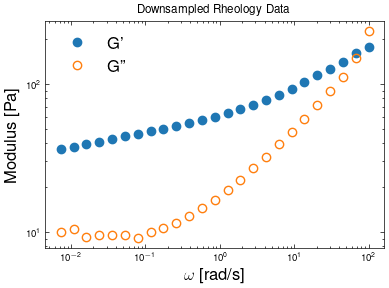

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))

# Plot Storage and Loss modulus
plt.plot(omega, G_prime, 'o', markersize=6, color='#1f77b4', label="G'")
plt.plot(omega, G_double_prime, 'o', markersize=6, color='#ff7f0e', fillstyle="none", label="G''")

# Log-log axes
plt.xscale('log')
plt.yscale('log')

# Labels and legend
plt.xlabel('$\\omega$ [rad/s]', fontsize=12)
plt.ylabel('Modulus [Pa]', fontsize=12)
plt.legend(fontsize=12)

plt.title("Downsampled Rheology Data")
plt.tight_layout()
plt.show()


## Initial Sampling, Scaling, and Model Initialization

In this section, we conduct the initial exploration phase of our optimization process.


## Acquisition and Model Updating

In this section, we perform the exploitation phase of our optimization process. We iteratively generate new samples using the q-Expected Improvement (qEI) acquisition function, evaluate the objective function at these new sample points, and update our model accordingly.

### Iterative Optimization Process

For each iteration in the exploitation phase:
1. **Generate New Candidates**: We compute new candidate points using the qEI acquisition function.
2. **Evaluate Objective**: The objective function is evaluated at the new candidate points.
3. **Apply Scaling**: The new objective values are scaled using the previously defined MaxAbsScaler.
4. **Update Samples and Objectives**: The new sample and corresponding objective values (both original and scaled) are appended to the existing lists of samples and objective values. We also save the index of the new sample for tracking purposes.
5. **Update Tensors**: The updated samples and objective values are converted to tensors.
6. **Model Update**: The GP model is re-initialized and fitted using the updated data.
7. **Logging**: The iteration details, including the new sample and objective value, are printed.


In [23]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available?:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.get_device_name(0))


PyTorch version: 2.1.0
CUDA available?: True
Number of GPUs: 1
Current GPU: NVIDIA RTX A2000 12GB


In [37]:
import warnings
import time as timer
import torch
import numpy as np
from botorch.models.utils.assorted import InputDataWarning

warnings.filterwarnings("ignore", category=InputDataWarning)
device_choice = 'cpu'
device = torch.device(device_choice)
print("Using device:", device)


# --- Objective wrapper for Bayesian Optimization ---
def objective_bo_wrapper(x):
    return objective(x)

# --- BO Loop Parameters ---
results = []
best_model = None
best_objective_value_overall = float('-inf')
best_X_samples = None
best_y_samples = None
max_y_per_iteration = []

n_runs = 1
n_initial_points = 8
n_exploitation_iter = 500
no_improvement_limit = 10
tolerance = 1e-2
q_batch_size = 2

# --- BO Loop ---
for run in range(n_runs):
    print(f"\nRun {run + 1}/{n_runs}")

    # Initial Sobol sampling
    X_samples = sobol_sample(param_space, n_initial_points)
    y_samples = np.array([objective_bo_wrapper(x) for x in X_samples])

    X_samples_tensor = torch.tensor(X_samples, dtype=torch.double, device=device)
    y_samples_tensor = torch.tensor(y_samples, dtype=torch.double, device=device)

    bounds = torch.stack([
        torch.tensor(param_space[:, 0], dtype=torch.double, device=device),
        torch.tensor(param_space[:, 1], dtype=torch.double, device=device)
    ])

    print("Initial X_samples shape:", X_samples.shape)
    print("Initial y_samples shape:", y_samples.shape)

    # Initialize and train GP
    mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
    model = model.to(device)
    fit_gpytorch_mll(mll)

    # Exploitation loop
    objective_values = list(y_samples)
    times_per_iteration = []
    cumulative_time = 0
    best_objective_value_run = float('-inf')       # used for tolerance logic
    true_best_objective_value_run = float('-inf')  # always updated
    no_improvement_counter = 0

    for i in range(n_exploitation_iter):
        torch.manual_seed(42 + i)
        np.random.seed(42 + i)

        new_candidates = compute_qei_acquisition_function(
            model, y_samples_tensor, bounds, q_batch_size=q_batch_size
        )
        new_batch = new_candidates.detach().cpu().numpy()
        new_batch_y = [objective_bo_wrapper(x) for x in new_batch]

        X_samples = np.vstack([X_samples, new_batch])
        y_samples = np.append(y_samples, new_batch_y)
        X_samples_tensor = torch.tensor(X_samples, dtype=torch.double, device=device)
        y_samples_tensor = torch.tensor(y_samples, dtype=torch.double, device=device)
        objective_values.extend(new_batch_y)
        max_y_per_iteration.append(y_samples_tensor.max().cpu().numpy())

        start_time = timer.time()
        mll, model = initialize_model(X_samples_tensor, y_samples_tensor)
        model = model.to(device)
        fit_gpytorch_mll(mll)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        iteration_time = timer.time() - start_time
        times_per_iteration.append(iteration_time)
        cumulative_time += iteration_time

        print(f"Exploitation {i + 1}/{n_exploitation_iter} - Batch values: {new_batch_y}")

        batch_best = max(new_batch_y)

        # Always track the true best (for reporting at the end)
        if batch_best > true_best_objective_value_run:
            true_best_objective_value_run = batch_best

        # Keep tolerance-based logic for early stopping
        improvement = batch_best - best_objective_value_run
        if improvement > tolerance:
            best_objective_value_run = batch_best
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= no_improvement_limit:
            print(f"Stopping early due to no significant improvement in the last {no_improvement_limit} iterations.")
            break

    if best_objective_value_run > best_objective_value_overall:
        best_objective_value_overall = best_objective_value_run
        best_model = model
        best_X_samples = X_samples
        best_y_samples = y_samples

    results.append({
        'objective_values': objective_values,
        'times_per_iteration': times_per_iteration,
        'cumulative_time': cumulative_time,
        'best_objective_value_run': true_best_objective_value_run  # ✅ use the true best
    })


# --- Print summary ---
for idx, res in enumerate(results):
    print(f"\nResults from Run {idx + 1}:")
    print("Objective values:", res['objective_values'])
    print("Best objective value in this run:", res['best_objective_value_run'])
    print("Total cumulative time:", res['cumulative_time'])

print("\nOverall best objective value:", best_objective_value_overall)
if best_model:
    print("Best X_samples from the best run:", best_X_samples)
    print("Best y_samples from the best run:", best_y_samples)
else:
    print("No best model found")

max_y_per_iteration = np.array(max_y_per_iteration)


Using device: cpu

Run 1/1
Initial X_samples shape: (8, 4)
Initial y_samples shape: (8,)
Exploitation 1/500 - Batch values: [-1.277179811883483, -1.3708884876383585]
Exploitation 2/500 - Batch values: [-1.343860834329599, -1.5548353023419907]
Exploitation 3/500 - Batch values: [-1.4234307057444082, -1.567956083770992]
Exploitation 4/500 - Batch values: [-2.089656852049421, -1.3887952455675896]
Exploitation 5/500 - Batch values: [-1.2568332042587367, -1.2850969881703989]
Exploitation 6/500 - Batch values: [-1.6583494348441454, -1.616139449833957]
Exploitation 7/500 - Batch values: [-2.1028331198454344, -1.1844448955424738]
Exploitation 8/500 - Batch values: [-1.2083924952066067, -0.9443264324739744]
Exploitation 9/500 - Batch values: [-1.4223881460694783, -1.5013207231365189]
Exploitation 10/500 - Batch values: [-0.7895077951554746, -1.413508108921548]
Exploitation 11/500 - Batch values: [-0.4845826391206937, -0.1399858930414769]
Exploitation 12/500 - Batch values: [-0.14629821033641033

## Visualizing Optimization Progress

In this section, we plot the negative of the objective function values as a function of the number of iterations. This helps us visually assess the optimization progress and the performance of the Sobol and Expected Improvement (EI) sampling strategies.

### Steps Involved in the Plotting Process:

1. **Configure the Plot**:
   We set the figure size and layout for constrained layout setting for better spacing.
   
2. **Prepare Data for Plotting**:
   - We create an array representing the iterations.
   - We negate the objective function values (`neg_objective_values`) because we are minimizing the objective, and lower values represent better performance.

3. **Plot the Sobol and EI Samples**:
   - Plot the initial Sobol samples in one color (`#89BFA9`), marking them as 'Sobol'.
   - Plot the subsequent EI samples in another color (`#60568A`), marking them as 'EI'.

4. **Customize Plot Appearance**:
   - Set the limits for the x-axis.
   - Label the x-axis as the number of iterations (`$n$`).
   - Label the y-axis as the log of the Residual Sum of Squares (RSS) weighted by true values (`$\\log$ RSS$_{w_{i}}$`).
   - Customize the font size of axis labels and tick labels.
   - Add a legend to distinguish between Sobol and EI samples.
  
5. **Display the Plot**:
   - Show the plot using `plt.show()`.
   
6. **Print the Minimum Objective Value**:
   - Print the minimum value of the negated objective values to see the best objective value achieved during the optimization process.


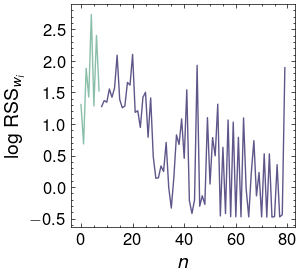

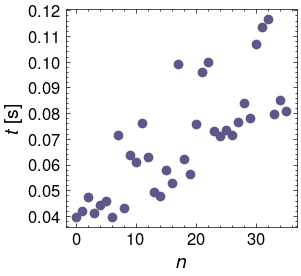

Run 1: The minimum value of the objective function in log10 scale is -0.4770
Run 1: Cumulative time for all iterations: 2.4843 seconds


In [38]:
# Prepare the figure for Objective Values
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)

# Iterate over results from each run and plot
for idx, res in enumerate(results):
    objective_values = res['objective_values']
    iterations = np.arange(len(objective_values))
    neg_objective_values = -np.array(objective_values)

    # Plot initial Sobol samples
    plt.plot(
        iterations[:n_initial_points],
        neg_objective_values[:n_initial_points],
        '-', 
        markersize=6, 
        label=f'Run {idx+1} Sobol',
        color='#89BFA9'
    )

    # Plot EI samples
    plt.plot(
        iterations[n_initial_points:], 
        neg_objective_values[n_initial_points:], 
        '-', 
        markersize=6,
        label=f'Run {idx+1} logEI',
        color='#60568A'
    )

# Customize Plot Appearance
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$\\log$ RSS$_{w_{i}}$', fontsize=14)           # Y-axis label
plt.xticks(fontsize=12)                                   # X-axis tick label size
plt.yticks(fontsize=12)                                   # Y-axis tick label size
#plt.legend(fontsize=10, loc="best")                       # Display legend

# Display or Save the Plot
plt.savefig("combined_fig_ei_oscillation_chia.pdf")
plt.show()

# Prepare the figure for Time per Iteration
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)

# Iterate over results from each run and plot time per iteration
for idx, res in enumerate(results):
    times_per_iteration = res['times_per_iteration']
    iterations = np.arange(len(times_per_iteration))

    plt.plot(
        iterations[:len(times_per_iteration)], 
        times_per_iteration, 
        'o', 
        markersize=6, 
        label=f'Run {idx+1} Time', 
        color='#60568A'
    )

# Customize Plot Appearance
plt.xlabel('$n$', fontsize=14)                            # X-axis label
plt.ylabel('$t$ [s]', fontsize=14)                        # Y-axis label
plt.xticks(fontsize=12)                                   # X-axis tick label size
plt.yticks(fontsize=12)                                   # Y-axis tick label size
#plt.legend(fontsize=10, loc="best")                       # Display legend

# Display or Save the Time Plot
plt.savefig("combined_fig_time_per_iteration.pdf")
plt.show()

# Print Minimum Objective Values and Cumulative Time for Each Run
for idx, res in enumerate(results):
    neg_objective_values = -np.array(res['objective_values'])
    cumulative_time = res['cumulative_time']
    print(f"Run {idx + 1}: The minimum value of the objective function in log10 scale is {np.min(neg_objective_values):.4f}")
    print(f"Run {idx + 1}: Cumulative time for all iterations: {cumulative_time:.4f} seconds")


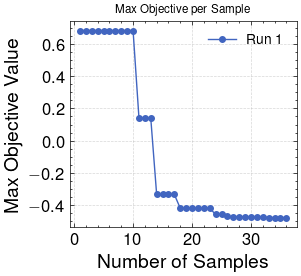

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ------------------------------
# Plot Max Objective per Sample (from results)
# ------------------------------
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)

all_runs_data = {}

for idx, res in enumerate(results):
    max_y = max_y_per_iteration  # NumPy array with max y per sample
    num_samples = np.arange(1, len(max_y) + 1)  # x-axis = total samples evaluated
    
    plt.plot(
        num_samples,
        -max_y,  # Negate if your objective is minimization
        '-o',
        markersize=4,
        label=f'Run {idx+1}',
        color=f'C{idx}'  # automatic color cycle
    )
    
    # Store results for saving
    all_runs_data[f"Run_{idx+1}"] = -max_y

# Convert to DataFrame
df = pd.DataFrame(all_runs_data, index=num_samples)
df.index.name = "Num_Samples"

# Save to CSV
#df.to_csv("optimization_path_matern_1.5.csv")

# Customize plot
plt.xlabel('Number of Samples', fontsize=14)
plt.ylabel('Max Objective Value', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10, loc="best")
plt.title('Max Objective per Sample')
plt.grid(True, linestyle='--', alpha=0.5)

# Save and show plot
plt.savefig("max_objective_per_sample.pdf")
plt.show()


## Fitting and Visualizing the Model with Best Parameters from Bayesian Optimization

In this section, we:
1. Define the fractional model evaluator.
2. Extract and print the best parameters obtained from the Bayesian Optimization (BO) phase.
3. Fit the model using the best parameters and compute the model values.
4. Calculate the Residual Sum of Squares (RSS) for the fitted model.
5. Plot the original data, the fitted model from Bayesian Optimization, and the optimized model.


Best parameters from Bayesian Optimization: G = 64.781228991, V = 5.540258855, alpha = 0.776655206, beta = 0.125760409
RSS_w for the Bayesian Optimization model: 0.3334229065


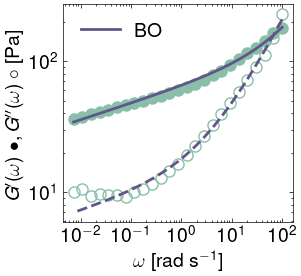

In [40]:
from cycler import cycler  # Import the cycler for customizing plot cycles

# Define model evaluator
fractional_model_name = "FractionalKelvinVoigt"
evaluator = SAOSEvaluator(model=fractional_model_name)

# Extract the best parameters from Bayesian Optimization phase
best_idx = np.argmax(best_y_samples)
best_params = best_X_samples[best_idx]
logG_best, logV_best, alpha_best, beta_best = best_params
G_best_bo = 10 ** logG_best
V_best_bo = 10 ** logV_best

# Print the best parameters from Bayesian Optimization
print("Best parameters from Bayesian Optimization: G = {:.9f}, V = {:.9f}, alpha = {:.9f}, beta = {:.9f}".format(G_best_bo, V_best_bo, alpha_best, beta_best))

# Fit the model with the best parameters from Bayesian Optimization
best_params_no_scale = G_best_bo, V_best_bo, alpha_best, beta_best
bo_model_values = evaluator.compute_model(best_params_no_scale, omega)

# Compute the RSS for the Bayesian Optimization model
rss_bo = np.sum(((G_prime - bo_model_values[0]) / G_prime) ** 2) + np.sum(((G_double_prime - bo_model_values[1]) / G_double_prime) ** 2)
print(f"RSS_w for the Bayesian Optimization model: {rss_bo:.10f}")

# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the data, the fitted model from Bayesian Optimization, and the final optimized model
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)
plt.plot(omega, G_prime, 'o', markersize=8, color='#89BFA9')
plt.plot(omega, G_double_prime, 'o', color='#89BFA9', fillstyle="none", markersize=8)
plt.plot(omega, bo_model_values[0], '-', color='#60568A', lw=2, label='BO')
plt.plot(omega, bo_model_values[1], '--', color='#60568A', lw=2)

# Configure the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\omega$ [rad s$^{-1}$]', fontsize=14)
plt.ylabel(r'$G^{\prime}(\omega)~\bullet, G^{\prime \prime}(\omega)~\circ$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

# Display the plot
plt.savefig("fig_bo_fit_oscillation_data_chia.pdf")
plt.show()

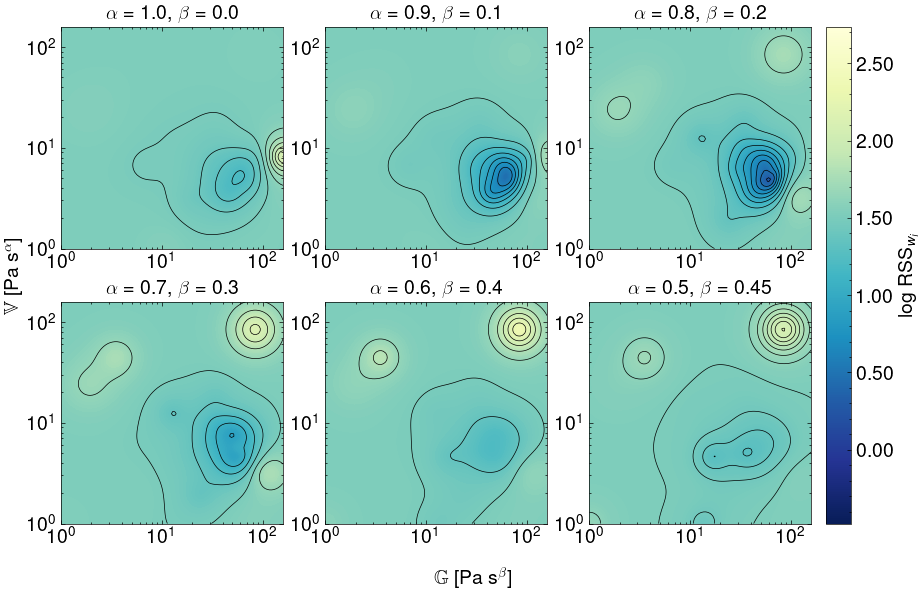

In [41]:
import matplotlib.colors as mcolors


def predict_model_on_grid_2D(model, param_space, alpha_value, beta_value, resolution=100):
    # Create a 2D mesh grid over logG and logV on device
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution, device=device, dtype=torch.double)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution, device=device, dtype=torch.double)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value)  # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value)    # keep beta fixed

    param_grid = torch.stack([
        logG_grid.reshape(-1),
        logV_grid.reshape(-1),
        alpha_grid.reshape(-1),
        beta_grid.reshape(-1)
    ], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_1 = model.posterior(param_grid).mean.detach().cpu().numpy().reshape(logG_grid.shape)

    # Move grids back to CPU for plotting
    return logG_grid.cpu(), logV_grid.cpu(), preds_1


# Define specific (alpha, beta) pairs to plot
alpha_beta_pairs = [
    (1.0, 0.0),
    (0.90, 0.1),
    (0.80, 0.2),
    (0.7, 0.3),
    (0.6, 0.4),
    (0.50, 0.45)
]

resolution = 100

# Ensure these values are correctly calculated
min_val, max_val = (-max(objective_values), -min(objective_values))

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(9, 5.5), constrained_layout=True)
contours_list = []

global_minima = []  # To store global minima parameters

for ax, (alpha, beta) in zip(axes.flatten(), alpha_beta_pairs):
    logG_grid, logV_grid, preds_obj1 = predict_model_on_grid_2D(best_model, param_space, alpha, beta, resolution)
    
    # Convert logG and logV to G and V (on CPU for plotting)
    G = 10 ** logG_grid.numpy()
    V = 10 ** logV_grid.numpy()

    # Take negative predictions because of the sign inversion
    neg_preds_obj1 = -1 * preds_obj1
    
    # Find global minima
    min_index = np.unravel_index(neg_preds_obj1.argmin(), neg_preds_obj1.shape)
    global_min_logG = logG_grid[min_index]
    global_min_logV = logV_grid[min_index]
    global_min_G = 10**global_min_logG
    global_min_V = 10**global_min_logV
    global_min_value = neg_preds_obj1[min_index]
    global_minima.append((global_min_G.item(), global_min_V.item(), 10**global_min_value))
    
    # Create the 2D contour plot for Objective 1
    contour = ax.contourf(G, V, neg_preds_obj1, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
    contours_list.append(contour)
    ax.contour(G, V, neg_preds_obj1, levels=10, colors='black', linewidths=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(f'$\\alpha$ = {alpha}, $\\beta$ = {beta}', fontsize=14)

# Create a ScalarMappable with the same colormap and normalization
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Add a single colorbar for all subplots
cbar = fig.colorbar(sm, ax=axes, location='right', aspect=20, pad=0.02, format='%.2f')
cbar.set_label('$\\log$ RSS$_{w_{i}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Add common labels
fig.text(0.5, -0.05, '$\mathbb{G}$ [Pa s$^{\\beta}$]', ha='center', va='center', fontsize=14)
fig.text(-0.01, 0.5, '$\mathbb{V}$ [Pa s$^{\\alpha}$]', ha='center', va='center', rotation='vertical', fontsize=14)

# Save the plot and show
plt.savefig("fig_obj1_oscillation_chia.pdf")
plt.show()

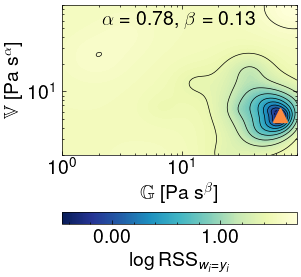

In [42]:
import matplotlib.colors as mcolors

def predict_model_mean_on_grid_2D(model, param_space, alpha_value, beta_value, resolution=100):
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value) # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value) # keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), alpha_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_mean = model.posterior(param_grid).mean.numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_mean

alpha = alpha_best
beta = beta_best
resolution = 100

# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj_mean = predict_model_mean_on_grid_2D(best_model, param_space, alpha, beta, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj_mean), -np.min(preds_obj_mean))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj_mean = -1 * preds_obj_mean  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj_mean, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj_mean, levels=10, colors='black', linewidths=0.5)
plt.plot(G_best_bo, V_best_bo, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 90)
plt.ylim(2, 90)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\mathbb{V}$ [Pa s$^{\\alpha}$]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, rf'$\alpha = {alpha_best:.2f}$, $\beta = {beta_best:.2f}$', 
         fontsize=14, ha='center', va='center', color='black', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$\log{{\\rm{RSS}}_{w_{i}=y_{i}}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.invert_xaxis()

# Save and display
plt.savefig("fig_obj1_oscillation_chia_solution_mean.pdf")
plt.show()

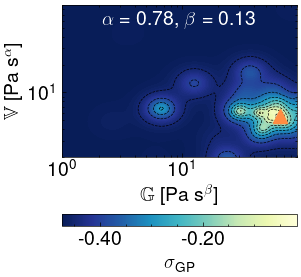

In [51]:
import matplotlib.colors as mcolors

def predict_model_std_on_grid_2D(model, param_space, alpha_value, beta_value, resolution=100):
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value) # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value) # keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), alpha_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    # Predict using the trained model
    with torch.no_grad():
        preds_std = model.posterior(param_grid).variance.sqrt().numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_std

alpha = alpha_best
beta = beta_best
resolution = 100

# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj_std = predict_model_std_on_grid_2D(best_model, param_space, alpha, beta, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj_std), -np.min(preds_obj_std))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj_std = -1 * preds_obj_std  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj_std, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj_std, levels=10, colors='black', linewidths=0.5)
plt.plot(G_best_bo, V_best_bo, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 90)
plt.ylim(2, 90)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\mathbb{V}$ [Pa s$^{\\alpha}$]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9,     rf'$\alpha = {alpha_best:.2f}$, $\beta = {beta_best:.2f}$', 
         fontsize=14, ha='center', va='center', color='white', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$\sigma_{\\rm{GP}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.invert_xaxis()

# Save and display
plt.savefig("fig_obj1_oscillation_chia_solution_std.pdf")
plt.show()

Using top-100 values instead of local maxima.
Detected peak candidates:
G=48.853, V=3.981, value=-0.1780
G=32.442, V=6.310, value=-0.1753
G=77.426, V=5.412, value=-0.1744
G=77.426, V=5.142, value=-0.1665
G=30.824, V=5.995, value=-0.1663
G=66.408, V=6.989, value=-0.1699
G=46.416, V=6.641, value=-0.1722
G=48.853, V=4.642, value=-0.1662
G=51.418, V=4.410, value=-0.1722
G=29.286, V=6.310, value=-0.1635
G=73.564, V=5.995, value=-0.1616
G=46.416, V=4.410, value=-0.1697
G=46.416, V=3.981, value=-0.1736
G=73.564, V=4.642, value=-0.1612
G=48.853, V=6.641, value=-0.1693
G=77.426, V=4.885, value=-0.1710
G=54.117, V=6.989, value=-0.1731
G=41.901, V=5.696, value=-0.1721
G=69.895, V=6.641, value=-0.1709
G=48.853, V=4.885, value=-0.1606
G=44.101, V=5.995, value=-0.0892
G=44.101, V=6.310, value=-0.1171
G=66.408, V=4.642, value=-0.1285
G=44.101, V=5.696, value=-0.1332
G=66.408, V=4.885, value=-0.0700
G=66.408, V=5.142, value=-0.0327
G=66.408, V=5.412, value=-0.0196
G=48.853, V=5.142, value=-0.1461
G=66

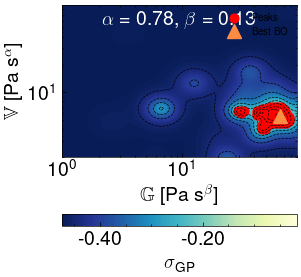

In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.feature import peak_local_max

# === Function for prediction on 2D grid ===
def predict_model_std_on_grid_2D(model, param_space, alpha_value, beta_value, resolution=100):
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value)
    beta_grid = torch.full_like(logG_grid, beta_value)

    param_grid = torch.stack(
        [logG_grid.reshape(-1),
         logV_grid.reshape(-1),
         alpha_grid.reshape(-1),
         beta_grid.reshape(-1)], dim=-1)

    with torch.no_grad():
        preds_std = model.posterior(param_grid).variance.sqrt().numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, preds_std


# === Parameters ===
alpha = alpha_best
beta = beta_best
resolution = 100

# Predict GP std surface
logG_grid, logV_grid, preds_obj_std = predict_model_std_on_grid_2D(
    best_model, param_space, alpha, beta, resolution
)

# Prepare values
min_val, max_val = (-np.max(preds_obj_std), -np.min(preds_obj_std))
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()
neg_preds_obj_std = -1 * preds_obj_std  # inverted

# === Peak detection ===
data = neg_preds_obj_std

# (1) Try local maxima
coordinates = peak_local_max(
    data,
    min_distance=2,
    threshold_abs=None,
    threshold_rel=0.0,
    exclude_border=False,
    num_peaks=0
)

# (2) If too few peaks, fall back to top-N highest points
N = 100  # number of peaks to mark
if len(coordinates) < 2:
    flat_indices = np.argpartition(data.ravel(), -N)[-N:]
    rows, cols = np.unravel_index(flat_indices, data.shape)
    coordinates = np.vstack([rows, cols]).T
    print(f"Using top-{N} values instead of local maxima.")

# Convert to actual values
peaks_G = G[coordinates[:, 0], coordinates[:, 1]]
peaks_V = V[coordinates[:, 0], coordinates[:, 1]]
peaks_values = data[coordinates[:, 0], coordinates[:, 1]]

print("Detected peak candidates:")
for g, v, val in zip(peaks_G, peaks_V, peaks_values):
    print(f"G={g:.3f}, V={v:.3f}, value={val:.4f}")


# === Plotting ===
plt.figure(figsize=(3, 2.75), constrained_layout=True)

contour = plt.contourf(G, V, data,
                       levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, data, levels=10, colors='black', linewidths=0.5)

# Mark detected peaks
plt.scatter(peaks_G, peaks_V, marker="o", color="red", s=40, label="Peaks")

# Optionally mark your BO best point
plt.plot(G_best_bo, V_best_bo, "^", color="#FF8C42", ms=10, label="Best BO")

plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 90)
plt.ylim(2, 90)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\mathbb{V}$ [Pa s$^{\\alpha}$]', fontsize=14)

plt.text(0.5, 0.9, rf'$\alpha = {alpha_best:.2f}$, $\beta = {beta_best:.2f}$',
         fontsize=14, ha='center', va='center', color='white',
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$\sigma_{\\rm{GP}}$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.legend()
plt.savefig("fig_obj1_detected_peaks.pdf")
plt.show()


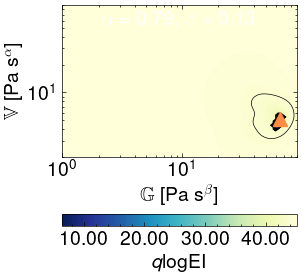

In [44]:
import matplotlib.colors as mcolors

def compute_logei_grid(model, param_space, alpha_value, beta_value, best_f, resolution=100):
    # Create a 2D mesh grid over logG and log_eta
    logG_range = torch.linspace(param_space[0, 0], param_space[0, 1], resolution)
    logV_range = torch.linspace(param_space[1, 0], param_space[1, 1], resolution)

    logG_grid, logV_grid = torch.meshgrid(logG_range, logV_range, indexing="ij")
    alpha_grid = torch.full_like(logG_grid, alpha_value) # keep alpha fixed
    beta_grid = torch.full_like(logG_grid, beta_value) # keep beta fixed

    param_grid = torch.stack([logG_grid.reshape(-1), logV_grid.reshape(-1), alpha_grid.reshape(-1), beta_grid.reshape(-1)], dim=-1)

    acq_func = qLogExpectedImprovement(
        model=model,
        best_f=best_f
    )

    # Reshape for batched qEI input: [N, q=1, d]
    param_grid_q = param_grid.unsqueeze(1)

    with torch.no_grad():
        ei_vals = acq_func(param_grid_q).squeeze().numpy().reshape(logG_grid.shape)

    return logG_grid, logV_grid, ei_vals


alpha = alpha_best
beta = beta_best
resolution = 100
best_f = best_y_samples.max()  # If your objective values are stored in train_y


# Plotting
plt.figure(figsize=(3, 2.75), constrained_layout=True)

logG_grid, logV_grid, preds_obj_std = compute_logei_grid(best_model, param_space, alpha, beta, best_f, resolution)

# Min/Max values for color scaling
min_val, max_val = (-np.max(preds_obj_std), -np.min(preds_obj_std))

# Convert logG and logV to G and V
G = 10 ** logG_grid.numpy()
V = 10 ** logV_grid.numpy()

# Inverting predictions
neg_preds_obj_std = -1 * preds_obj_std  # Apply your scaler if needed

# 2D contour plot
contour = plt.contourf(G, V, neg_preds_obj_std, levels=100, vmin=min_val, vmax=max_val, cmap='YlGnBu_r')
plt.contour(G, V, neg_preds_obj_std, levels=10, colors='black', linewidths=0.5)
plt.plot(65.26, 5.19, "^", color="#FF8C42", ms=10)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 90)
plt.ylim(2, 90)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$\mathbb{G}$ [Pa s$^{\\beta}$]', fontsize=14)
plt.ylabel('$\mathbb{V}$ [Pa s$^{\\alpha}$]', fontsize=14)

# Title inside the plot
plt.text(0.5, 0.9, r'$\alpha = 0.79$, $\beta = 0.13$', 
         fontsize=14, ha='center', va='center', color='white', 
         transform=plt.gca().transAxes)

# Colorbar
norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
sm = plt.cm.ScalarMappable(cmap='YlGnBu_r', norm=norm)
sm.set_array([])

# Corrected colorbar axis
cbar = plt.colorbar(sm, ax=plt.gca(), location='bottom', aspect=20, pad=0.05, format='%.2f')
cbar.set_label('$q$logEI', fontsize=14)
cbar.ax.tick_params(labelsize=14)
#cbar.ax.invert_xaxis()

# Save and display
plt.savefig("fig_obj1_oscillation_chia_solution_qei.pdf")
plt.show()

In [45]:
# Objective function to minimize (RRS weighted by true values)
def objective_minimize(params, omega, G_prime, G_double_prime):
    logG, logV, alpha, beta = params
    G = 10 ** logG
    V = 10 ** logV
    params_no_scale = G, V, alpha, beta
    model = "FractionalKelvinVoigt"
    evaluator = SAOSEvaluator(model=model)
    
    # Compute oscillation data
    model_values = evaluator.compute_model(params_no_scale, omega)
    
    # Add noise
    error = createRandomError(omega.shape[0], 0.0)
    model_values_noisy = np.multiply(model_values, error)
    
    # Define objective function: sum of squared relative errors for G' and G''
    obj1 = np.sum(((G_prime - model_values_noisy[0]) / G_prime) ** 2) + np.sum(((G_double_prime - model_values_noisy[1]) / G_double_prime) ** 2)
    
    return obj1  # Return the raw error (we no longer need the -log10)

def callback(params):
    obj_value = objective_minimize(params, omega, G_prime, G_double_prime)
    current_errors.append(obj_value)

In [46]:
import numpy as np
from scipy.optimize import minimize
import time as timer
from collections import defaultdict

# -------------------------------
# Custom bounds from param_space
# -------------------------------
custom_bounds = [(low, high) for (low, high) in param_space]

# -------------------------------
# Initial guesses from Sobol or random points
# -------------------------------
n_initial_guesses = 8
initial_guesses_list = X_samples[:n_initial_guesses].tolist()

# -------------------------------
# Prepare storage
# -------------------------------
results_spy = []
cumulative_times = {method: 0.0 for method in ['L-BFGS-B', 'Nelder-Mead', 'Powell']}
method_paths = defaultdict(list)

# -------------------------------
# List of optimization methods
# -------------------------------
methods = ['L-BFGS-B', 'Nelder-Mead', 'Powell']  # Add others if desired

# -------------------------------
# Start total timing
# -------------------------------
start_time_total = timer.time()

# -------------------------------
# Multi-start optimization with error handling
# -------------------------------
for method in methods:
    print(f"\nRunning optimization with method: {method}")
    method_cumulative = 0.0

    for run_idx, initial_guess in enumerate(initial_guesses_list):
        best_so_far = []

        # Evaluate initial guess before iterations
        init_val = objective_minimize(initial_guess, omega, G_prime, G_double_prime)
        best_so_far.append(init_val)

        # Callback function for tracking progress
        def callback_fn(xk):
            val = objective_minimize(xk, omega, G_prime, G_double_prime)
            # monotone "best so far" tracking
            best_so_far.append(min(val, best_so_far[-1]))


        # Options
        if method == 'Nelder-Mead':
            options = {'xatol': 1e-9, 'fatol': 1e-9, 'maxfev': 2000, 'disp': True}
        elif method in ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell']:
            options = {'ftol': 1e-9, 'maxiter': 1000, 'disp': True}
        else:
            options = {'maxiter': 1000, 'disp': True}

        # Bounds
        bounds = custom_bounds if method in ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'Nelder-Mead'] else None

        # -------------------------------
        # Time this run
        # -------------------------------
        start_time_iter = timer.time()

        try:
            res = minimize(
                objective_minimize,
                initial_guess,
                args=(omega, G_prime, G_double_prime),
                method=method,
                bounds=bounds,
                callback=callback_fn if method not in ['TNC'] else None,
                options=options
            )

            elapsed_time_iter = timer.time() - start_time_iter
            method_cumulative += elapsed_time_iter

            n_iterations = len(best_so_far)

            # Store results
            results_spy.append({
                'method': method,
                'initial_guess': initial_guess,
                'result': res,
                'time': elapsed_time_iter,
                'path': best_so_far,
                'iterations': n_iterations
            })
            method_paths[(method, run_idx)] = best_so_far

            print(f"Completed initial guess {run_idx+1}/{len(initial_guesses_list)} "
                  f"in {elapsed_time_iter:.4f} s; fun = {res.fun:.6f}; "
                  f"iterations = {n_iterations}")

        except Exception as e:
            elapsed_time_iter = timer.time() - start_time_iter
            print(f"Skipping initial guess {run_idx+1} due to error: {e}")
            continue

    cumulative_times[method] = method_cumulative
    print(f"\nCumulative time for {method}: {method_cumulative:.4f} s")

# -------------------------------
# Total elapsed time
# -------------------------------
total_time = timer.time() - start_time_total
print(f"\nTotal optimization time for all methods: {total_time:.4f} seconds")

# -------------------------------
# Extract function values and optimized parameters
# -------------------------------
function_values = [entry['result'].fun for entry in results_spy]
optimized_parameters = [entry['result'].x for entry in results_spy]
individual_times = [entry['time'] for entry in results_spy]
iteration_counts = [entry['iterations'] for entry in results_spy]

# -------------------------------
# Select best result
# -------------------------------
best_idx = np.argmin(function_values)
best_fun = function_values[best_idx]
best_params = optimized_parameters[best_idx]

print(f"\nBest objective value: {best_fun}")
print(f"Best parameters (logG_i): {best_params}")
print(f"Time for best run: {individual_times[best_idx]:.4f} s")
print(f"Iterations for best run: {iteration_counts[best_idx]}")

# -------------------------------
# Print cumulative times per method
# -------------------------------
print("\nCumulative times per method:")
for method, cum_time in cumulative_times.items():
    print(f"{method}: {cum_time:.4f} s")

# -------------------------------
# Print iteration counts per initial guess
# -------------------------------
print("\nIteration counts per initial guess:")
for idx, entry in enumerate(results_spy):
    print(f"Initial guess {idx+1}: {entry['iterations']} iterations")



Running optimization with method: L-BFGS-B
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03108D+01    |proj g|=  1.10000D+00

At iterate    1    f=  9.32884D+00    |proj g|=  1.53695D+00

At iterate    2    f=  3.55073D+00    |proj g|=  1.70260D+00

At iterate    3    f=  2.46969D+00    |proj g|=  1.75483D+00

At iterate    4    f=  2.41080D+00    |proj g|=  1.83336D+00

At iterate    5    f=  2.28115D+00    |proj g|=  1.75519D+00

At iterate    6    f=  1.92324D+00    |proj g|=  1.69423D+00

At iterate    7    f=  1.30360D+00    |proj g|=  1.46281D+00

At iterate    8    f=  9.64386D-01    |proj g|=  1.52864D+00

At iterate    9    f=  5.78507D-01    |proj g|=  1.50827D+00

At iterate   10    f=  4.09417D-01    |proj g|=  1.56530D+00

At iterate   11    f=  3.34382D-01    |proj g|=  2.24795D-01

At iterate   12    f=  3.33717D-01    |proj 

In [47]:
# -------------------------------
print("\nCumulative times per method:")
for method, cum_time in cumulative_times.items():
    print(f"{method}: {cum_time:.4f} s")


Cumulative times per method:
L-BFGS-B: 0.0654 s
Nelder-Mead: 0.1853 s
Powell: 0.2086 s


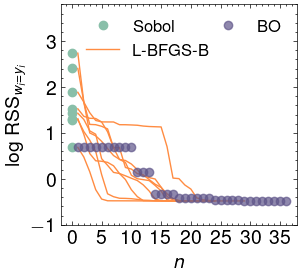

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Define colors for each method
# -------------------------------
colors = {'L-BFGS-B': '#FF8C42', 'Nelder-Mead': '#89BFA9', 'Powell': '#60568A'}

# -------------------------------
# Prepare figure
# -------------------------------
plt.figure(figsize=(3, 2.75), constrained_layout=True)

# Plot initial Sobol samples
plt.plot(
    np.zeros(n_initial_points),
    neg_objective_values[:n_initial_points],
    'o', 
    markersize=6, 
    label='Sobol',
    color='#89BFA9'
    )

# -------------------------------
# Plot optimization paths
# -------------------------------
for method in ['L-BFGS-B']:
    # Filter results for this method
    method_results = [res for res in results_spy if res['method'] == method]

    for idx, res_entry in enumerate(method_results):
        # Use intermediate function values if stored in res_entry['path'], otherwise just final value
        if 'path' in res_entry:
            path_values = np.array(res_entry['path'])
        else:
            path_values = np.array([res_entry['result'].fun])  # fallback to single value

        # Number of iterations
        iterations = np.arange(1, len(path_values) + 1)

        # Plot path
        plt.plot(
            iterations,
            np.log10(path_values),
            '-', 
            markersize=4,
            alpha=1,
            color=colors[method],
            label=method if idx == 0 else ""  # label only first run per method
        )

# -------------------------------
# Optional: overlay Bayesian Optimization iterations
# -------------------------------
objective_values = max_y_per_iteration  # From BO
iterations = np.arange(1, len(objective_values) + 1)
neg_objective_values_bo = -np.array(objective_values)

plt.plot(
    iterations,
    neg_objective_values_bo,
    "o",
    markersize=6, alpha=0.7,
    color='#60568A',
    label='BO'
)



# -------------------------------
# Customize plot
# -------------------------------
plt.xlabel('$n$', fontsize=14)
plt.ylabel('$\\log$ RSS$_{w_{i}=y_{i}}$', fontsize=14)
#plt.xlim(-5, 100)
plt.ylim(-1, 3.8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=12, loc='upper right', ncols=2, columnspacing=0.1)

# -------------------------------
# Save and display
# -------------------------------
plt.savefig("fig_ei_oscillation_chia_comparison.pdf")                    # Uncomment to save the plot
plt.show()


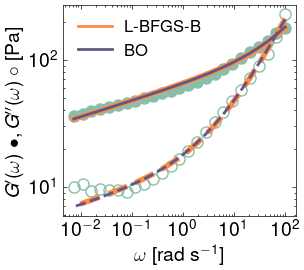

In [49]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

# Choose which method to plot
method_to_plot = 'L-BFGS-B'
method_color = '#FF8C42'  # color for this method
legend_lw = 2

# Create the plot
plt.figure(figsize=(3, 2.75))

# -------------------------------
# Plot experimental data
# -------------------------------
plt.plot(omega, G_prime, 'o', markersize=8, color='#89BFA9', label="G' (data)")
plt.plot(omega, G_double_prime, 'o', color='#89BFA9', fillstyle="none", markersize=8, label="G'' (data)")

# -------------------------------
# Plot best result for the selected method
# -------------------------------
method_results = [res for res in results_spy if res['method'] == method_to_plot]
if method_results:
    best_result = min(method_results, key=lambda r: r['result'].fun)
    best_params = best_result['result'].x
    N_modes = len(best_params)

    Gp_model, Gpp_model = evaluator.compute_model(
        (10**best_params[0], 10**best_params[1], best_params[2], best_params[3]), omega
    )
    
    # Plot lines (thick)
    plt.plot(omega, Gp_model, '-', color=method_color, lw=4, label=f"{method_to_plot} fit G'")
    plt.plot(omega, Gpp_model, '--', color=method_color, lw=4, label=f"{method_to_plot} fit G''")

# -------------------------------
# Plot BO solution (optional)
# -------------------------------
plt.plot(omega, bo_model_values[0], '-', color='#60568A', lw=2, label='BO')
plt.plot(omega, bo_model_values[1], '--', color='#60568A', lw=2)

# -------------------------------
# Configure axes
# -------------------------------
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\omega$ [rad s$^{-1}$]', fontsize=14)
plt.ylabel(r'$G^{\prime}(\omega)~\bullet, G^{\prime \prime}(\omega)~\circ$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# -------------------------------
# Custom legend
# -------------------------------
handles = [
    mlines.Line2D([], [], color=method_color, lw=legend_lw, label=method_to_plot),
    mlines.Line2D([], [], color='#60568A', lw=legend_lw, label='BO'),
    #mlines.Line2D([], [], color='#89BFA9', lw=1, marker='o', linestyle='None')
]
plt.legend(handles=handles, fontsize=12)

# -------------------------------
# Save and show
# -------------------------------
plt.savefig("fig_bo_fit_oscillation_data_chia_comparison.pdf")
plt.show()


Best parameters from Bayesian Optimization: G = 5.500000000, V = 7.000000000, alpha = 0.776655206, beta = 0.125760409
RSS_w for the Bayesian Optimization model: 26.5137239416


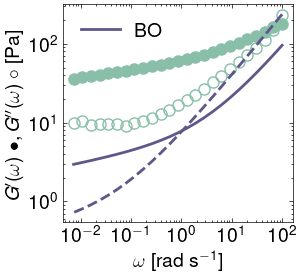

In [73]:
from cycler import cycler  # Import the cycler for customizing plot cycles

# Define model evaluator
fractional_model_name = "FractionalKelvinVoigt"
evaluator = SAOSEvaluator(model=fractional_model_name)

# Extract the best parameters from Bayesian Optimization phase
best_idx = np.argmax(best_y_samples)
best_params = best_X_samples[best_idx]
logG_best, logV_best, alpha_best, beta_best = best_params
G_best_bo = 5.5
V_best_bo = 7

# Print the best parameters from Bayesian Optimization
print("Best parameters from Bayesian Optimization: G = {:.9f}, V = {:.9f}, alpha = {:.9f}, beta = {:.9f}".format(G_best_bo, V_best_bo, alpha_best, beta_best))

# Fit the model with the best parameters from Bayesian Optimization
best_params_no_scale = G_best_bo, V_best_bo, alpha_best, beta_best
bo_model_values = evaluator.compute_model(best_params_no_scale, omega)

# Compute the RSS for the Bayesian Optimization model
rss_bo = np.sum(((G_prime - bo_model_values[0]) / G_prime) ** 2) + np.sum(((G_double_prime - bo_model_values[1]) / G_double_prime) ** 2)
print(f"RSS_w for the Bayesian Optimization model: {rss_bo:.10f}")

# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the data, the fitted model from Bayesian Optimization, and the final optimized model
plt.figure(figsize=(3.0, 2.75), constrained_layout=True)
plt.plot(omega, G_prime, 'o', markersize=8, color='#89BFA9')
plt.plot(omega, G_double_prime, 'o', color='#89BFA9', fillstyle="none", markersize=8)
plt.plot(omega, bo_model_values[0], '-', color='#60568A', lw=2, label='BO')
plt.plot(omega, bo_model_values[1], '--', color='#60568A', lw=2)

# Configure the plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\omega$ [rad s$^{-1}$]', fontsize=14)
plt.ylabel(r'$G^{\prime}(\omega)~\bullet, G^{\prime \prime}(\omega)~\circ$ [Pa]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

# Display the plot
plt.savefig("fig_bo_fit_oscillation_data_chia_second.pdf")
plt.show()